In [2]:
import numpy as np
#import mpmath
from scipy.integrate import solve_bvp
from scipy.optimize import root, minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

### Demo on using root_finder to solve constrained complex ODE system
ODE: y" + 2y' - ny = 0, y(0) = 1, y(1) = 0, n = 1+2j

Constraint: y'(1/2)*n - n^2 = 0

In [3]:
### analytic result by Wolfram Alpha
def y(x):
    # Precompute constants
    complex_term = (-1)**(1/8) * 2**(3/4)
    
    # Exponential terms
    numerator_1 = np.exp(2 * complex_term - (1 + complex_term) * x)
    numerator_2 = np.exp((complex_term - 1) * x)
    
    denominator = np.exp(2 * complex_term) - 1
    
    # Final result
    result = (numerator_1 - numerator_2) / denominator
    
    return result

### y'(1/2) from Wolfram Alpha
t = (-0.7880337393206961+0.09525152218711913j)
truth = t*(1+2j) - (1+2j)**2

In [4]:
x = np.linspace(0, 1, 1000)
initial_guess = np.ones((2, x.size), dtype=complex)

### 2nd order ODE
def fun(x, y, n):
    return np.vstack((y[1], -2*y[1] + n*y[0]))

### boundary condition y(0)=1, y(1)=0
def bc(ya, yb):
    return np.array([ya[0]-1-0j, yb[0]-0j])

### solve the ODE in each region for a given n
def solve_ode_for_n(n):
    sol = solve_bvp(lambda x, y: fun(x, y, n), bc, x, initial_guess, tol=1e-5)
    if sol.success:
        return sol
    else:
        raise ValueError("ODE solver failed to converge for n = {}".format(n))

# Function that relates y'(x) and n
def relation_between_y_and_n(yp, x, n):
    answer = yp*n - n**2 - truth
    return (np.real(answer))**2 + (np.imag(answer))**2

def gradient_helper(a, b, c, d):
    re = a*(c-a) - b*(d-b) - np.real(truth)
    im = b*(c-a) + a*(d-b) - np.imag(truth)
    return [2*re*(c-2*a)+2*im*(d-2*b), 2*re*(2*b-d)+2*im*(c-2*a)]

In [5]:
# Wrapper function to find the root (i.e., find n)
def find_n(x, guess):
    def constraint_and_deriavtive(n):
        solution = solve_ode_for_n(n)
        yp_values = solution.sol(x)[1]
        yp_val = interp1d(x, yp_values)(1/2)
        return relation_between_y_and_n(yp_val, x, n), yp_val

    def root_function(ns):
        n = ns[0] + ns[1]*1.0j
        res, _ = constraint_and_deriavtive(n)
        return res

    def gradient(ns):
        n = ns[0] + ns[1]*1.0j
        _, yp = constraint_and_deriavtive(n)
        return gradient_helper(ns[0], ns[1], np.real(yp), np.imag(yp))
    
    guess = guess # Initial guess for n
    n_solution = minimize(root_function, guess, tol=1e-5, method='L-BFGS-B', jac=gradient)
    
    return n_solution.x

# Find n that satisfies the relation
guess1 = np.array([2, 1])
guess2 = np.array([-5, 1])
n_final_sep1 = find_n(x, guess1)
n_final1 = n_final_sep1[0] + n_final_sep1[1]*1j
n_final_sep2 = find_n(x, guess2)
n_final2 = n_final_sep2[0] + n_final_sep2[1]*1j
print('n truth:', 1+2j)
print('n result:', n_final1, n_final2)

# Solve the ODE with the found n
final_solution1 = solve_ode_for_n(n_final1)
final_solution2 = solve_ode_for_n(n_final2)

# Extract the solution
y_values1 = final_solution1.sol(x)[0]
y_values2 = final_solution2.sol(x)[0]

n truth: (1+2j)
n result: (0.9999993117519103+1.9999935104700404j) (-1.8929789264059182-2.0251965405111956j)


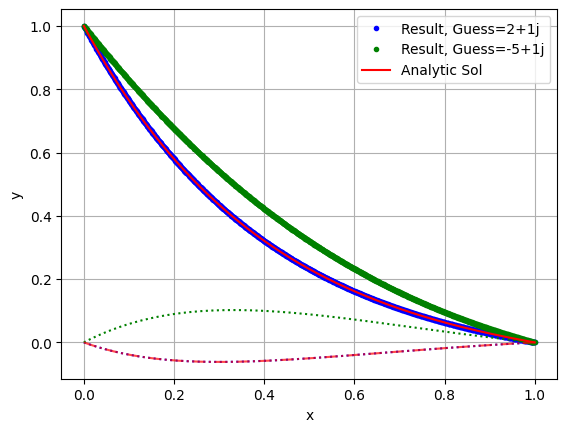

In [6]:
plt.plot(x, np.real(y_values1), 'b.', label='Result, Guess=2+1j')
plt.plot(x, np.imag(y_values1), 'b:')
plt.plot(x, np.real(y_values2), 'g.', label='Result, Guess=-5+1j')
plt.plot(x, np.imag(y_values2), 'g:')
plt.plot(x, np.real(y(x)), 'r-', label='Analytic Sol')
plt.plot(x, np.imag(y(x)), 'r', ls='-.', alpha=0.7)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

### Demo on using MCMC to solve constrained ODE system

41054it [08:24, 81.39it/s, batch: 1 | bound: 3 | nc: 1 | ncall: 705203 | eff(%):  5.297 | loglstar: -1.174 < -0.000 < -0.170 | logz: -6.112 +/-  0.045 | stop:  0.617]                


n real =  0.43 +/-  8.24, maxL_param =  4.16


(<Figure size 340x340 with 1 Axes>,
 array([[<Axes: title={'center': 'n real = ${3.86}_{-22.50}^{+0.33}$'}, xlabel='n real'>]],
       dtype=object))

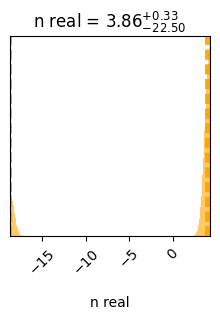

In [54]:
# Log-likelihood function
def log_likelihood(n):
    solution = solve_ode_for_n(n)
    yp_values = solution.sol(x)[1]
    g_n = relation_between_y_and_n(yp_values, x, n)
    log_l = -0.5 * np.log(g_n)**2 / sigma**2
    return log_l

# Prior transform function (Uniform prior for n)
def prior_transform(n):
    n_min = -20.0  # minimum value for n
    n_max = 20.0  # maximum value for n
    n = n_min + (n_max - n_min)*n
    return n

# Parameters and initial conditions
x = np.linspace(0, 1, 100)
initial_guess = np.ones((2, x.size), dtype=np.float64)
sigma = 0.1  # noise level in likelihood

# Set up the dynesty sampler
sampler = dynesty.DynamicNestedSampler(log_likelihood, prior_transform, ndim=1, bound='multi', nlive=3000, sample='rslice', bootstrap=None)

# Run the nested sampling
sampler.run_nested()

# Get the results
results = sampler.results

# Analyze results
samples = results.samples
# normalized weights
weights = np.exp(results.logwt - results.logz[-1])
# resample weighted samples with equal weights
samples_equal = dyfunc.resample_equal(samples, weights)
# results.summary()
# compute weighted mean and covariance
mean, cov = dyfunc.mean_and_cov(samples, weights)
errors = np.diagonal(cov)**0.5
maxL_index = results['logl'].argmax()
maxL_params = samples[maxL_index]
param_names = ['n real', 'n imag']
labels = ['n real', 'n imag']

title_quantiles = [0.16, 0.5, 0.84]
for ii in range(len(mean)):
    print('{0:5s} = {1:5.2f} +/- {2:5.2f}, maxL_param = {3:5.2f}'.format(param_names[ii],
                                                      mean[ii], errors[ii], maxL_params[ii]))
plt.close('all')
dyplot.runplot(results)
plt.close()
#plt.savefig(‘/Users/xuningyuan/Galactic_Center_YNC/eccentricity_dist/dnest_ecc_run_’ + suffix + ‘.png’)
dyplot.traceplot(results, labels=labels)
plt.close()
#plt.savefig(‘/Users/xuningyuan/Galactic_Center_YNC/eccentricity_dist/dnest_ecc_trace_’ + suffix + ‘.png’)
dyplot.cornerplot(results, labels=labels, color='orange', truth_color='blue', show_titles=True)
#plt.savefig(‘figures/corner_Ma-0.5_i70.png’, dpi=300, bbox_inches=‘tight’)